# Gaussian Inferences, t-Student, Update of Beliefs

In [25]:
%pip install pymc pytensor

In [26]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import requests
import pymc as pm

In [27]:
az.style.use('arviz-darkgrid')

%config InlineBackend.figure_format = 'retina'
print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v5.7.2
Running on ArviZ v0.15.1


The reference for this new exercise is [1] (one of our reference textbooks in our course), from which this exercise is taken.   

We use a dataset that comes from **Nuclear Magnetic Resonance (NMR)**, a powerful tehcnique that is used to study molecules.
NMR allows to measure *chemical shifts* from nuclei of certain types of atmos. In quantum chemistry chemical shifts correspond to a signal shift from a reference value in the chemical environemnt that we are studying.

We could have measured the height of a group of people or the average time to travel back home... it's the same thing.

We do not need that our data is truly Gaussian (or any other distribution): we only demand that a Guassian distribution is a resoanble approximation of our data.
For this example, we have 48 chemical shifts values that we can load into a NumPy array and plot by using the following code:


In [28]:
import io
import csv


target_url = 'https://raw.githubusercontent.com/cfteach/brds/main/datasets/chemical_shifts.csv'

download = requests.get(target_url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))


data=df.iloc[:,0].values

print(data)

[55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43 53.
 56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58 51.36
 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82 54.99
 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]


The KDE plot of this dataset shows a Gaussian-like distribution, except for two data points that are far away from the mean:

([<matplotlib.axis.YTick at 0x7ff47cc83fa0>], [Text(0, 0, '0')])

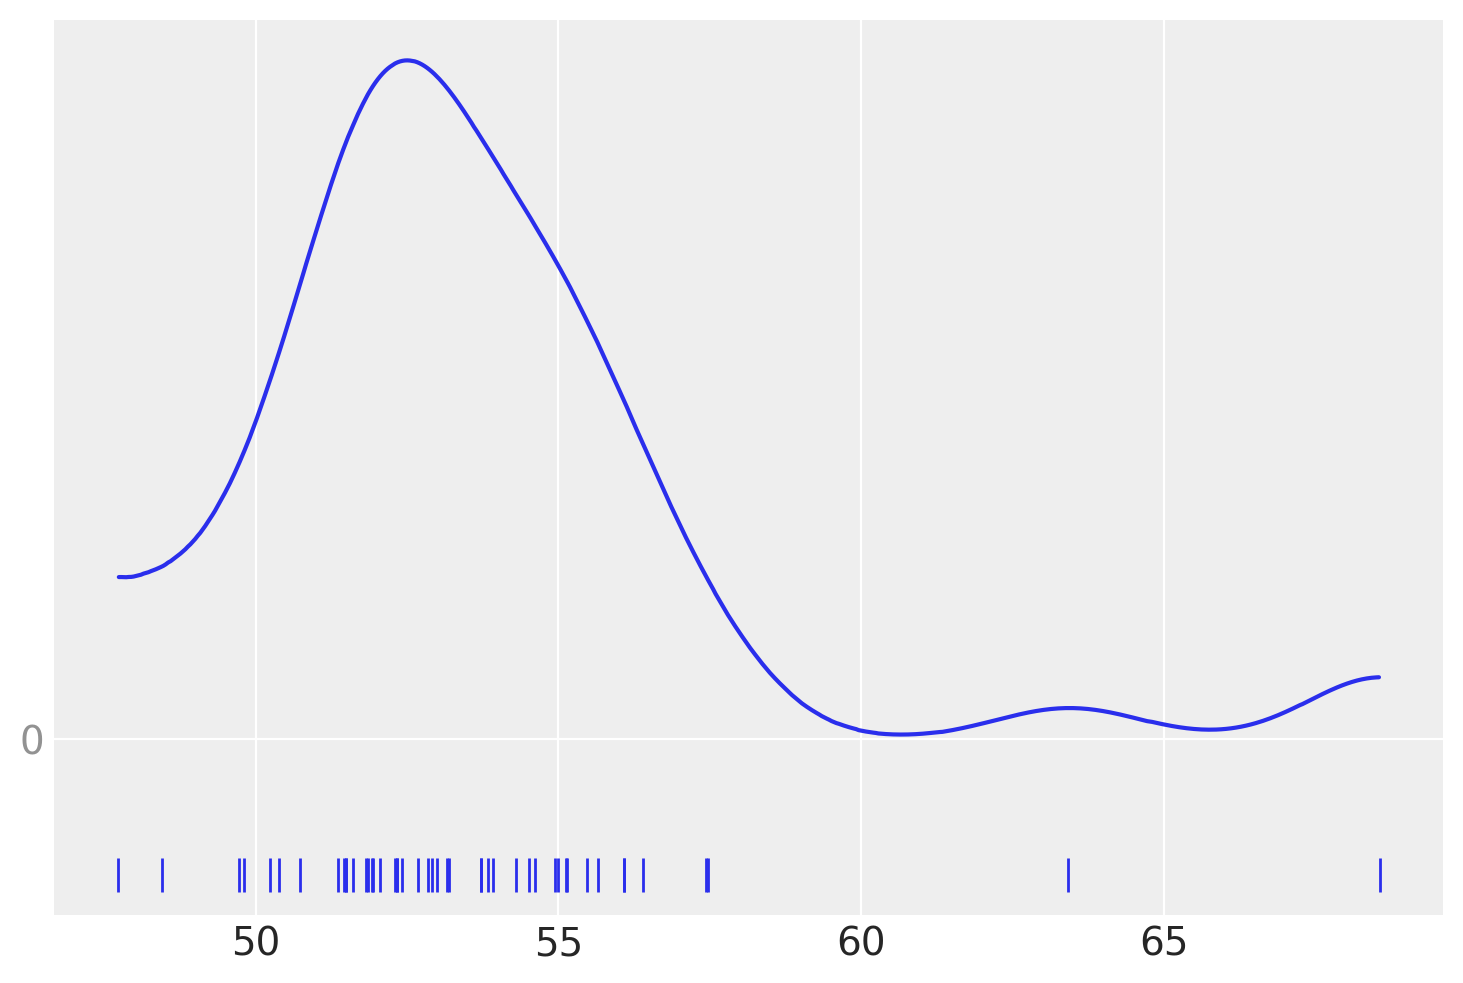

In [29]:
az.plot_kde(data, rug=True)

#rug plots https://en.wikipedia.org/wiki/Rug_plot

plt.yticks([0], alpha=0.5)

Let’s forget about those two “outliers” for a moment, and assume that a Gaussian distribution is a proper description of the data.



Since we do not know the mean and standard deviation, we must set priors for both of them.



Let’s build a resonable model; this could be:

$\mu$ $\sim$ $U(l,u)$

$\sigma$ $\sim$ |$\mathcal{N}(0,\sigma_{\sigma})$|

y $\sim$ $\mathcal{N}$($\mu$,$\sigma$)

**Question:** What is the meaning of this model?

If we do not know the possible values of $\mu$ and $\sigma$, we can set priors on them to reflect our ignorance on these parameters.

Using PyMC, we can write the model as follows:


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

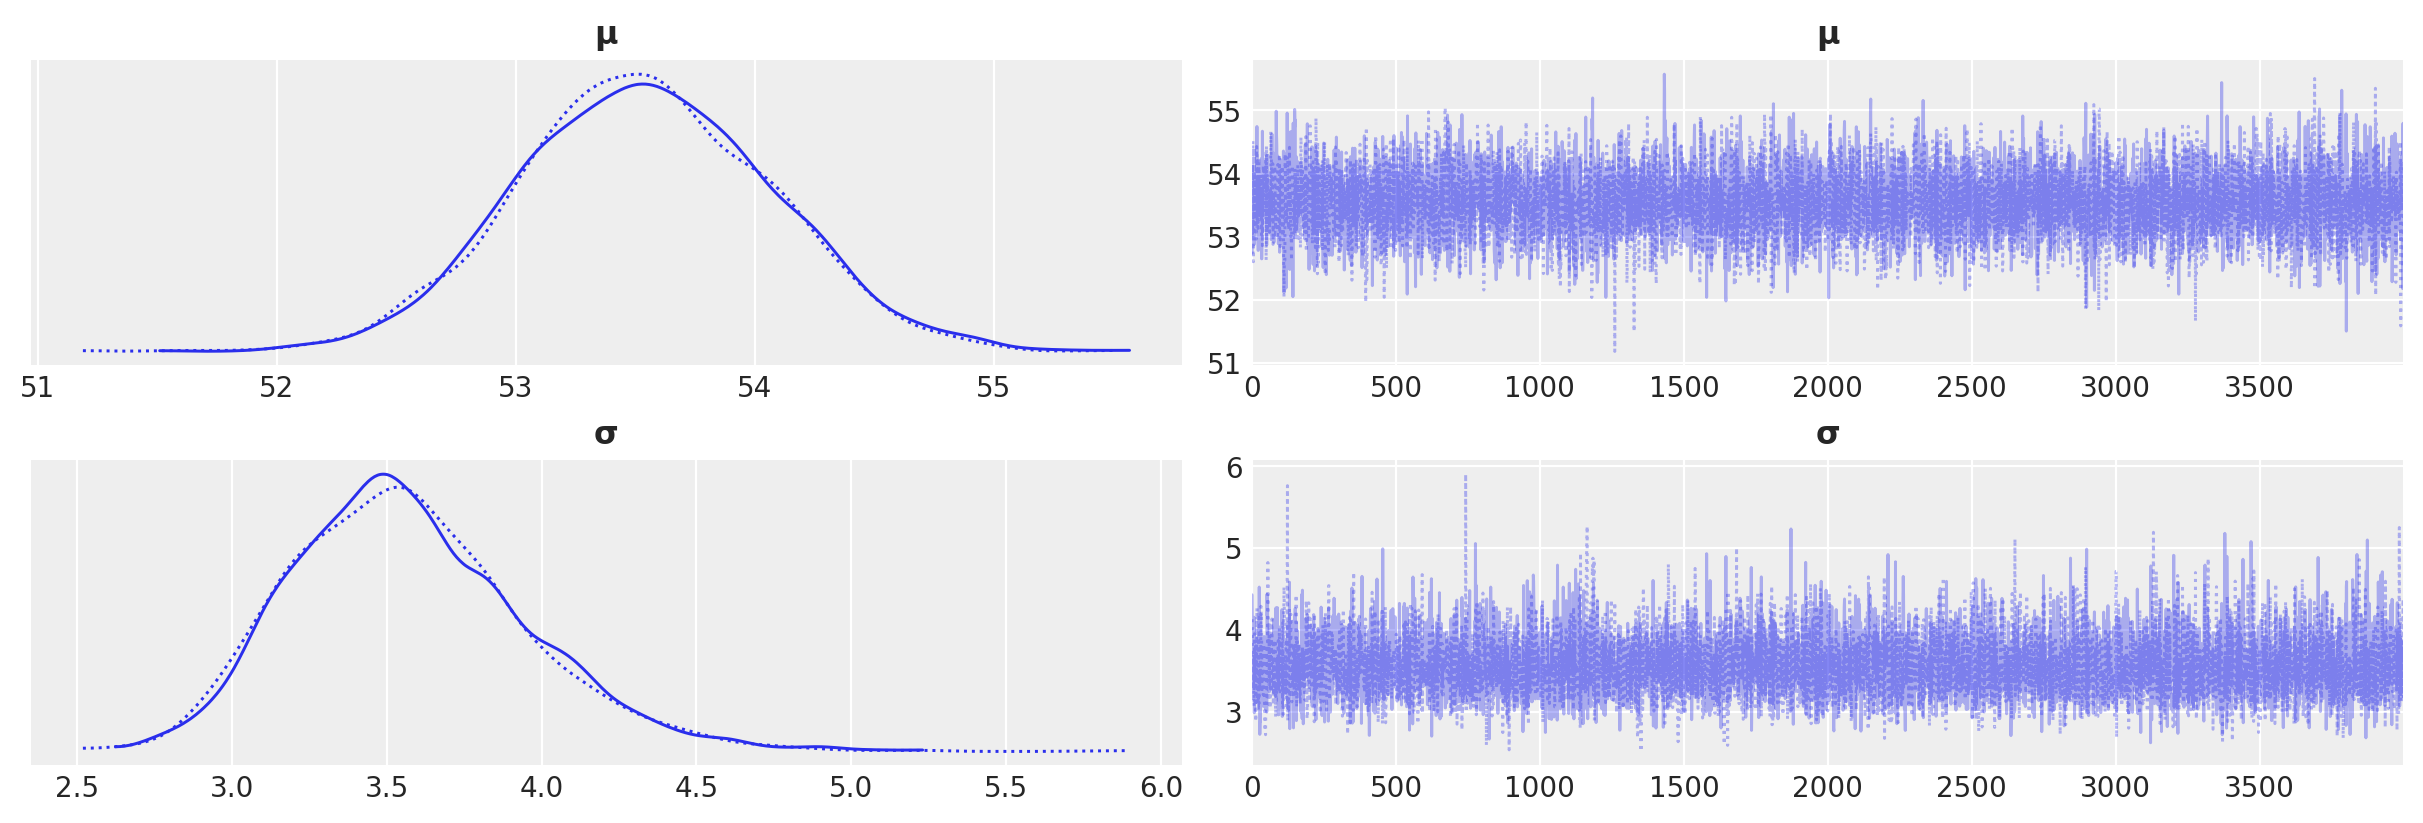

In [163]:
with pm.Model() as model_g:

    μ = pm.Uniform('μ', lower = 40, upper = 70)
    σ = pm.HalfNormal('σ', sigma = 10)
    y = pm.Normal('y', mu=μ, sigma =σ, observed=data)
    idata_g = pm.sample(4000)

az.plot_trace(idata_g)



array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

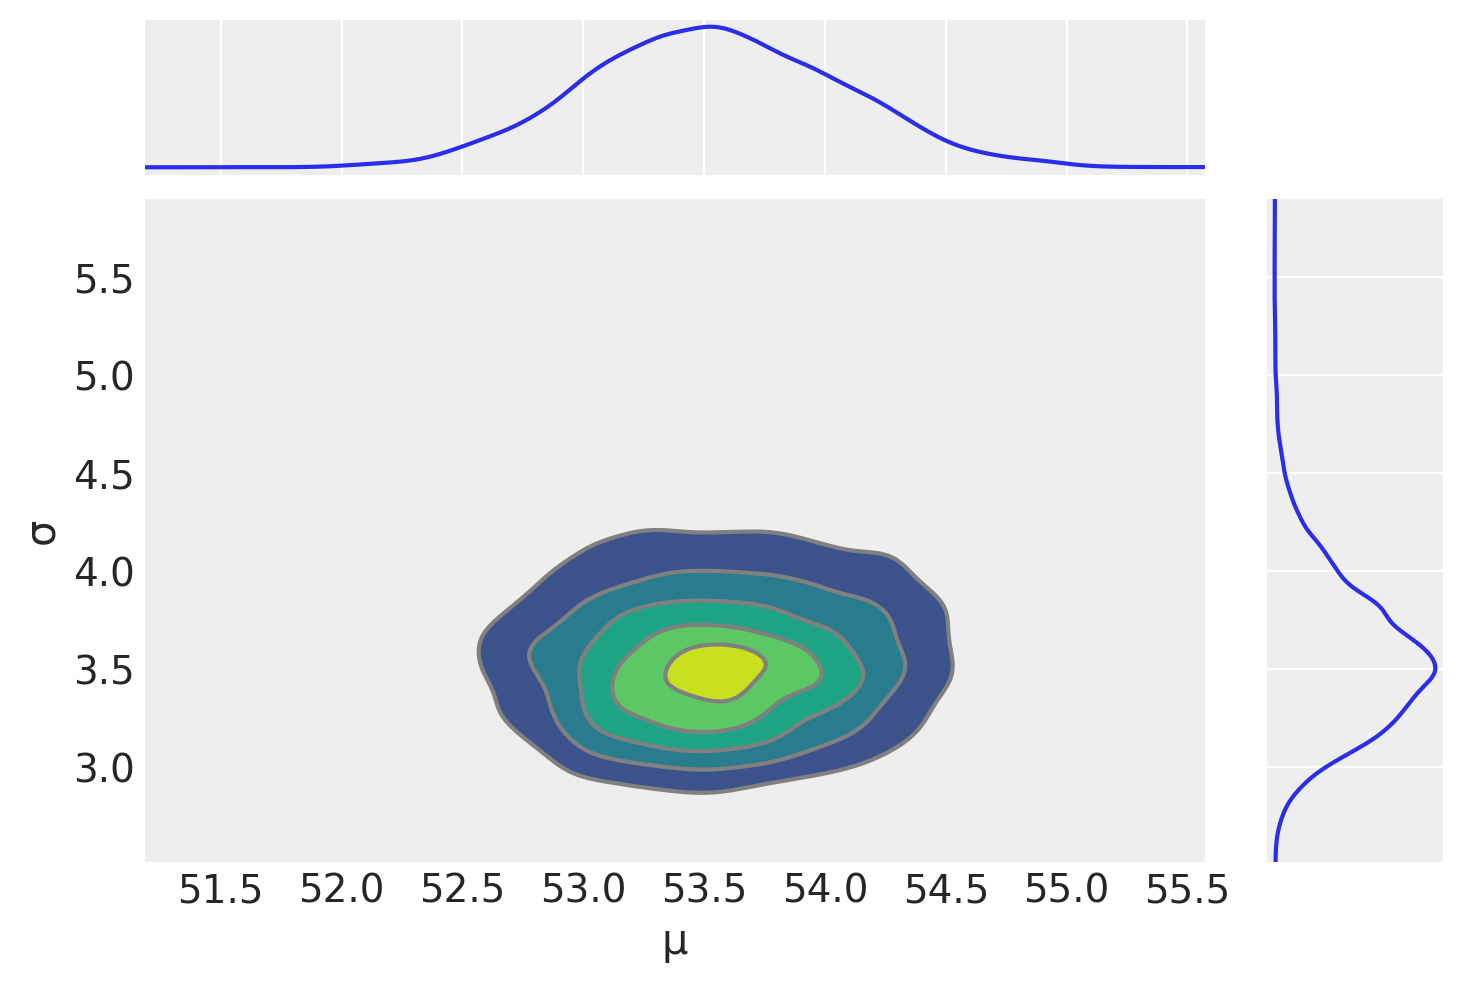

In [164]:
az.plot_pair(idata_g, kind='kde', marginals=True)

In [165]:
az.summary(idata_g)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.539  0.526  52.531   54.482      0.006    0.004    7741.0    5147.0   
σ   3.567  0.378   2.911    4.290      0.004    0.003    7673.0    5922.0   

   r_hat  
μ    1.0  
σ    1.0

Remember:

* *mcse*: Monte Carlo Standard Error. Monte Carlo Standard Error (MCSE) is another measure of accuracy of the chains. It is defined as standard deviation of the chains divided by their effective sample size.  

* *ess*: effective-sample size. ESS takes into account the autocorrelation within the chain, indicating the equivalent number of independent samples.

* *ess_bulk*: useful measure for sampling efficiency in the bulk of the distribution. The rule of thumb for ess_bulk is for this value to be greater than 100 per chain on average. Since we ran N chains, `we need ess_bulk to be greater than N*100 for each parameter`.

* *ess_tail*: compute a tail effective sample size estimate for a single variable. `The rule of thumb for this value is also to be greater than 100 per chain on average`.

* *r_hat*: diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. converges to unity when each of the traces is a sample from the target posterior. `Values greater than one indicate that one or more chains have not yet converged`.

### Predictive Checks

We can use the posterior to generate predictions --- e.g, each of which of the same size of the data. We can check consistency with data. This is a self-consistency check that is allowed by Bayesian Reasoning: it is possible to generate predictions $\tilde{y}$, based on data $y$, and the estimated parameters $\theta$:

$p(\tilde{y}|y)$=$\int{p(\tilde{y}|\theta)}p(\theta|y) d\theta$

We can use the predicted $\tilde{y}$ and compare to our data $y$ to criticize our model. Models should always be checked.

Ref: https://www.pymc-labs.com/blog-posts/out-of-model-predictions-with-pymc/

In [166]:
# let's generate 100 predictions from the posterior
y_pred_g = pm.sample_posterior_predictive(idata_g, model_g) #(trace_g, model_g)

Let's take a look at the dimensions

In [167]:
y_pred_g

Inference data with groups:
	> posterior_predictive
	> observed_data

In [168]:
y_pred_g.posterior_predictive

<xarray.Dataset>
Dimensions:  (chain: 2, draw: 4000, y_dim_2: 47)
Coordinates:
  * chain    (chain) int64 0 1
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 3993 3994 3995 3996 3997 3998 3999
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 8 9 ... 38 39 40 41 42 43 44 45 46
Data variables:
    y        (chain, draw, y_dim_2) float64 48.04 49.55 52.38 ... 50.62 53.6
Attributes:
    created_at:                 2024-02-13T16:32:53.178306
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.7.2

In [169]:
pred_y_ppc = y_pred_g.posterior_predictive['y'].values

shape_ppc = np.shape(pred_y_ppc)



Compare to number of chains, sample size of each chain, and the length of the original datasets.
We are basically creating multiple datasets "equivalent" to the original dataset, but through our posterior

In [170]:
print(f"n. chains: {shape_ppc[0]}, chain size: {shape_ppc[1]}, sample size: {shape_ppc[2]}")

print(np.shape(pred_y_ppc[0][3999]))

print(pred_y_ppc[0][3999])

print(pred_y_ppc[1][3999])

n. chains: 2, chain size: 4000, sample size: 47
(47,)
[54.56196887 45.84818176 56.91440002 51.78632963 50.42868409 58.65872661
 52.82409523 49.67824552 53.92985227 55.1898878  56.10804772 57.8379738
 51.28465596 53.86983622 50.88621908 50.18986171 52.98852019 53.48973493
 49.15396679 54.42875    51.89225678 50.29473982 53.99299552 51.78988797
 59.10511896 52.68648569 59.11030329 58.76436386 50.26512947 50.79346666
 52.08797544 47.40867226 46.78969642 56.74736867 53.08161053 51.90731529
 56.73095881 52.27390547 48.64009168 48.63594795 45.8177419  50.60600493
 44.9153624  50.60576934 55.79019098 53.98290113 51.63944768]
[52.58859073 53.96614959 50.52412449 56.63637902 53.09461248 55.12478532
 54.37482564 53.20338366 55.09473991 55.31263759 51.72874779 49.32984181
 56.51255649 53.40142983 50.4395486  53.70319971 52.55587006 57.54516864
 53.33227444 53.96576249 53.58650251 56.46331526 51.54540899 45.70885982
 58.71974489 51.44987348 54.7688283  55.25775929 53.29048747 51.79087913
 56.86680

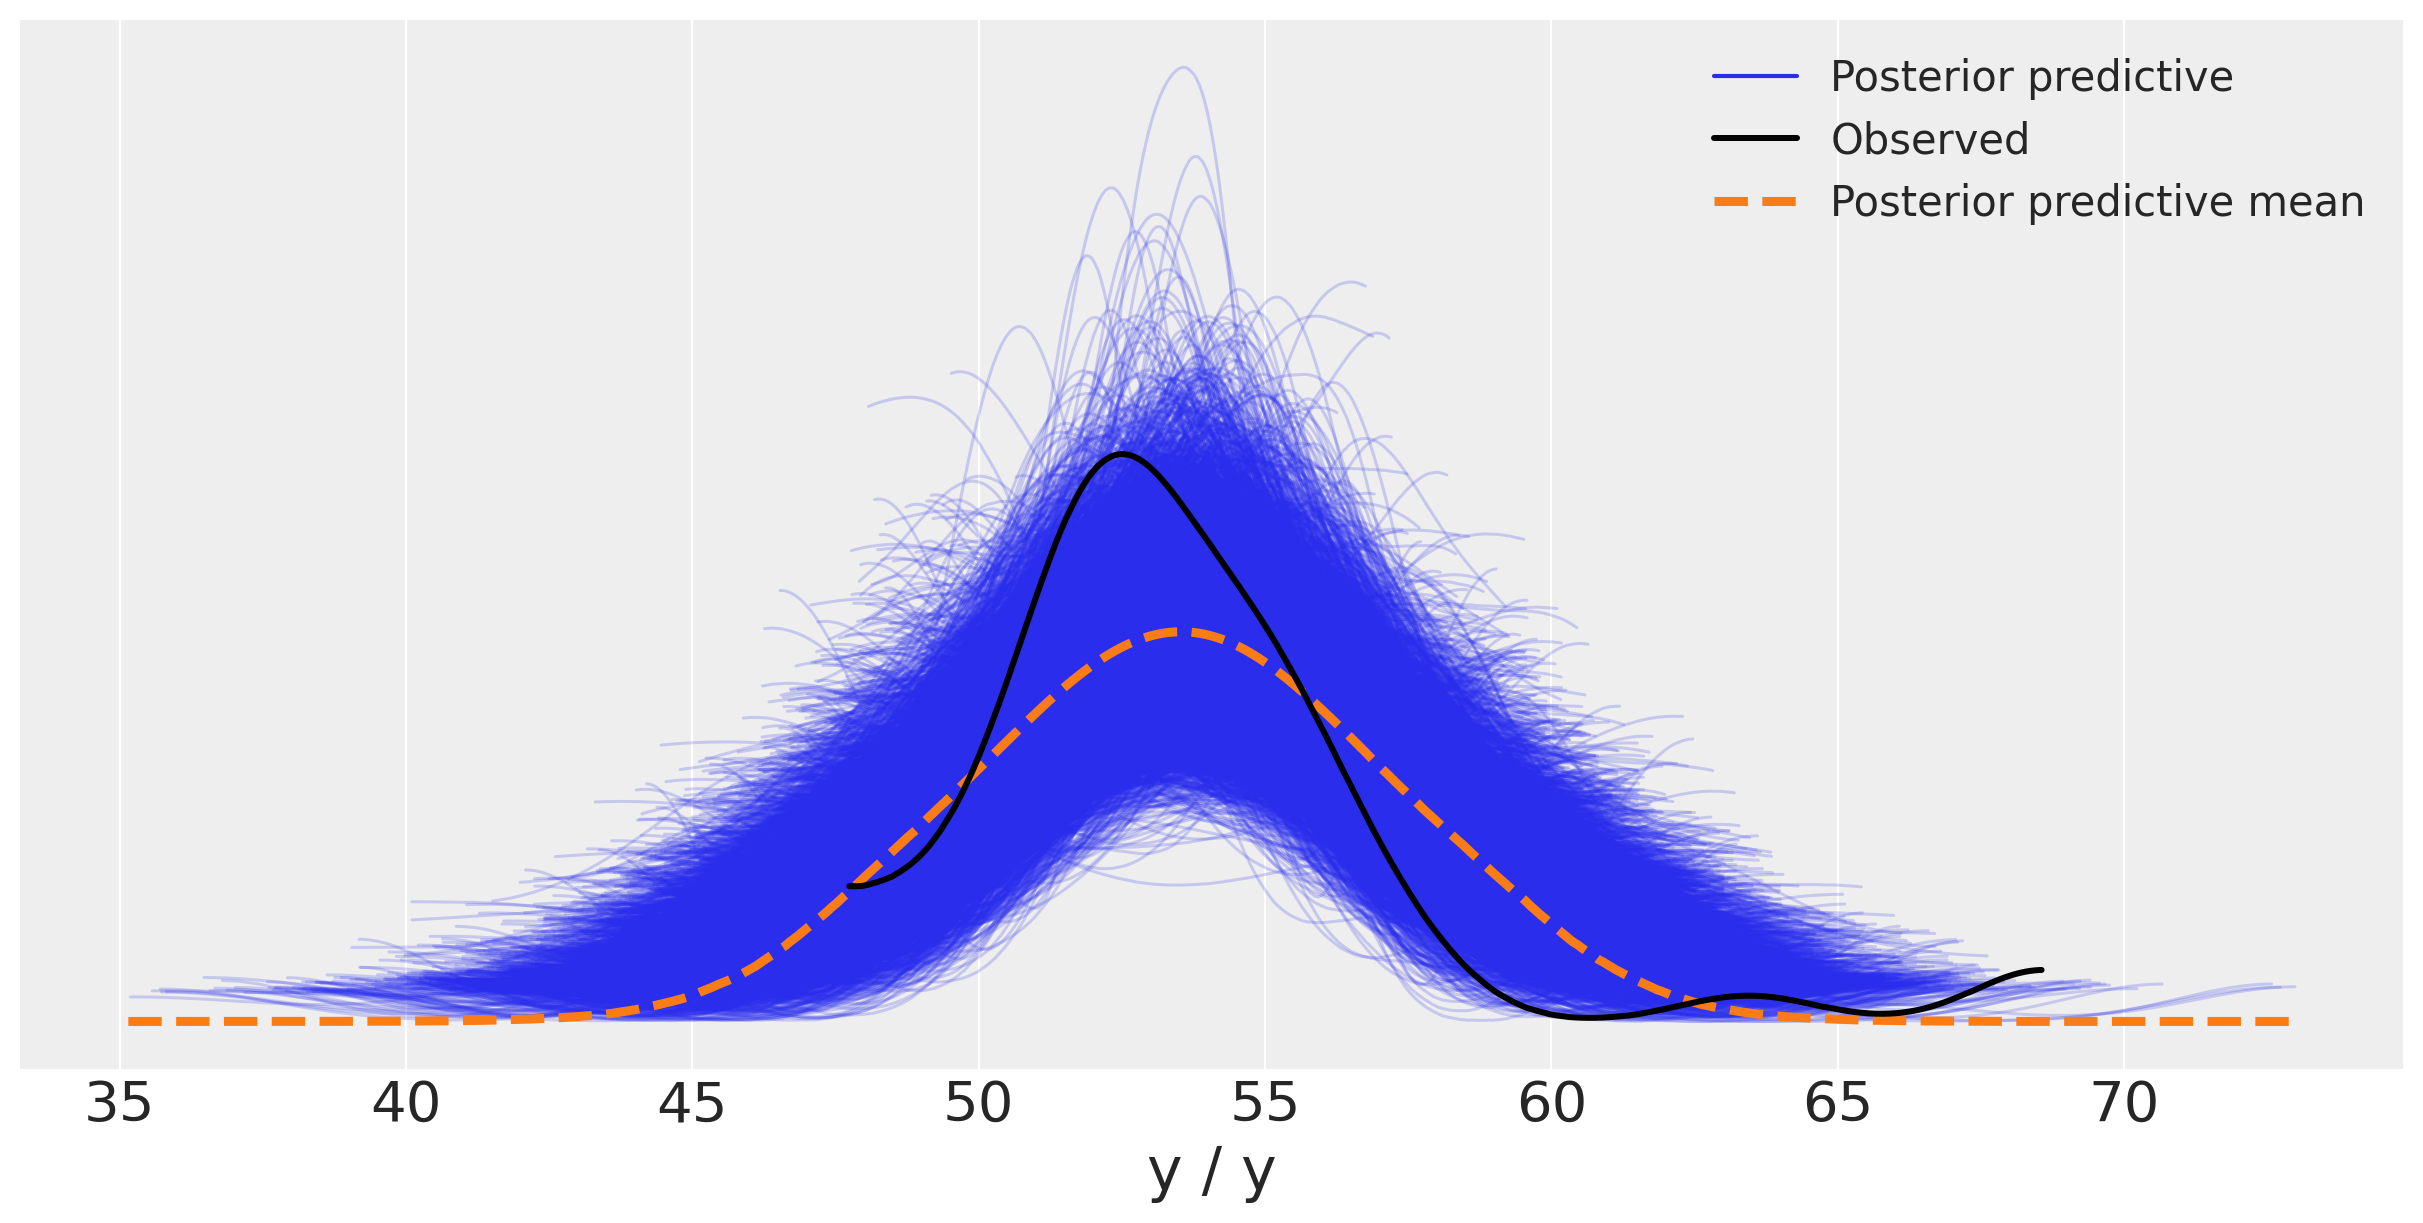

In [171]:
#data_ppc = az.from_pymc3(posterior_predictive=y_pred_g, model=model_g)
#data_ppc = az.from_pymc3(trace=trace_g, posterior_predictive=y_pred_g)

ax = az.plot_ppc(y_pred_g, figsize=(12,6), mean=True)
ax.legend(fontsize=15)

<div class="alert alert-block alert-info" style="background-color: white; border: 2px solid; padding: 10px">
    <b><i class="fa fa-info-circle" aria-hidden="true"></i>&nbsp; Note</b><br>
    <p style="color: black">
    You may argue that the two outliers at large values of the chemical shifts are influencing the results, i.e. making the Gaussian with a larger standard deviation. You can remove those outliers... Bayesian rather prefer to change the model with different priors and likelihoods, rather than ad hoc heuristics such as outlier removal.   
        
      
        
   </p>
</div>





One very useful option is replacing the Gaussian likelihood with a Student's t-distribution

### Student's t Distribution

https://en.wikipedia.org/wiki/Student%27s_t-distribution



*   Fun fact: origin of the name
*   Distribution



(-5.0, 5.0)

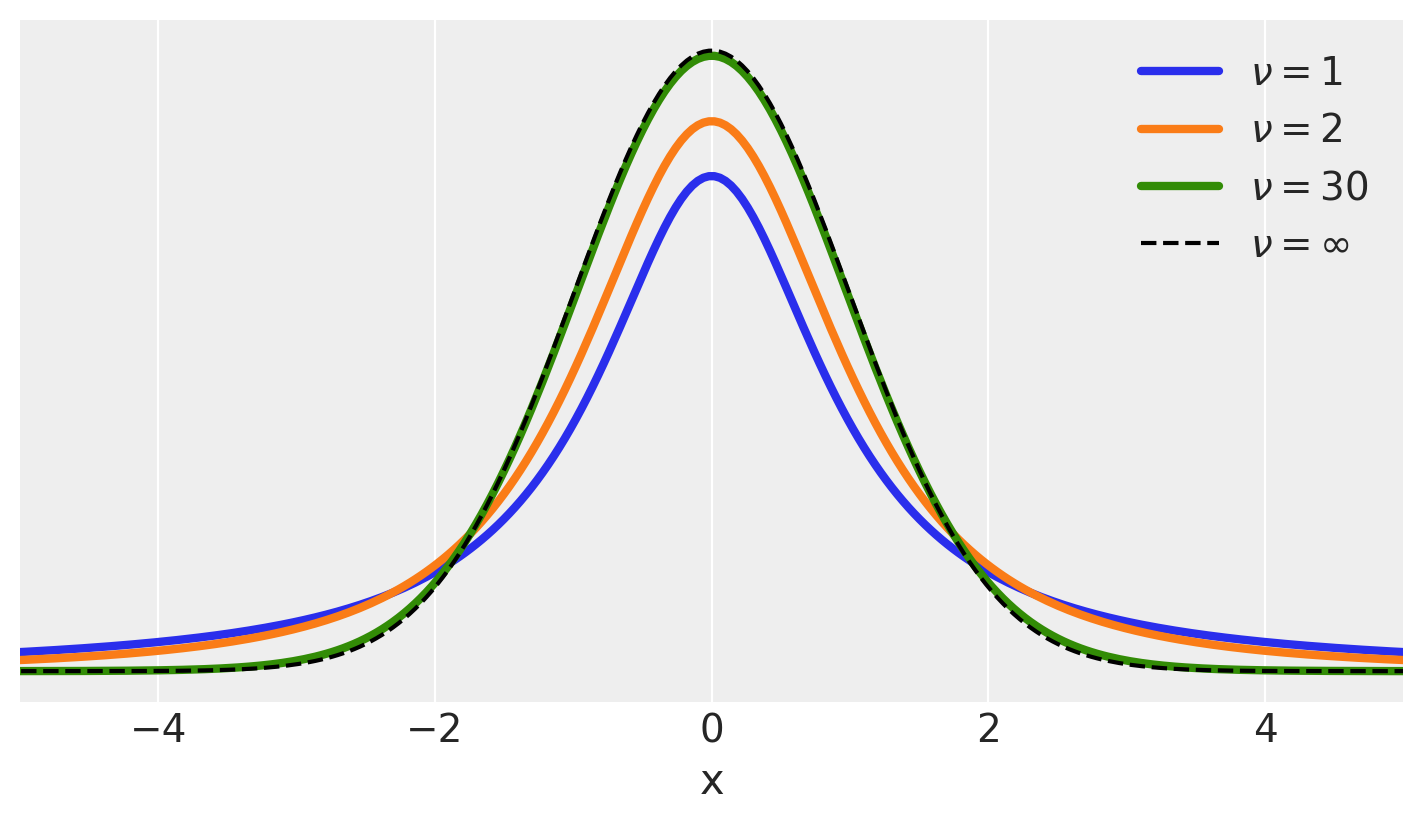

In [147]:
plt.figure(figsize=(7, 4))
x_values = np.linspace(-10, 10, 500)
for nu in [1, 2, 30]:
    distri = stats.t(nu)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=fr'$\nu = {nu}$', lw=3)

x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, 'k--', label=r'$\nu = \infty$') #normal
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-5, 5)

For the t-distribution, we now have three parameters to consider, $\mu$, $\sigma$ and $\nu$. Please see notes in class.

This will reflect in our model according to:



<block>

$\mu \sim U(l,u)$ --- uniform (**Prior on $\mu$**)

$\sigma \sim |\mathcal{N}(0,\sigma_{\sigma})|$ --- positive-defined and normal-like (**Prior on $\sigma$**)

$\nu \sim Exp(\lambda)$ --- exponential (**Prior on $\nu$**)

$y \sim \mathcal{T(\mu,\sigma, \nu)}$ --- t-Student (**Likelihood**)

</block>

In [172]:
with pm.Model() as model_t:

    μ = pm.Uniform('μ', 40, 75)
    σ = pm.HalfNormal('σ', sigma=10)
    ν = pm.Exponential('ν', 1/30)
    y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=data)
    idata_t = pm.sample(1000,tune=5000,return_inferencedata=True)

#  step size adaptation, which gives you fewer parameters to tune, and adds in the concept of “warmup” or “tuning” for your sampler.
# https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Exponential.html

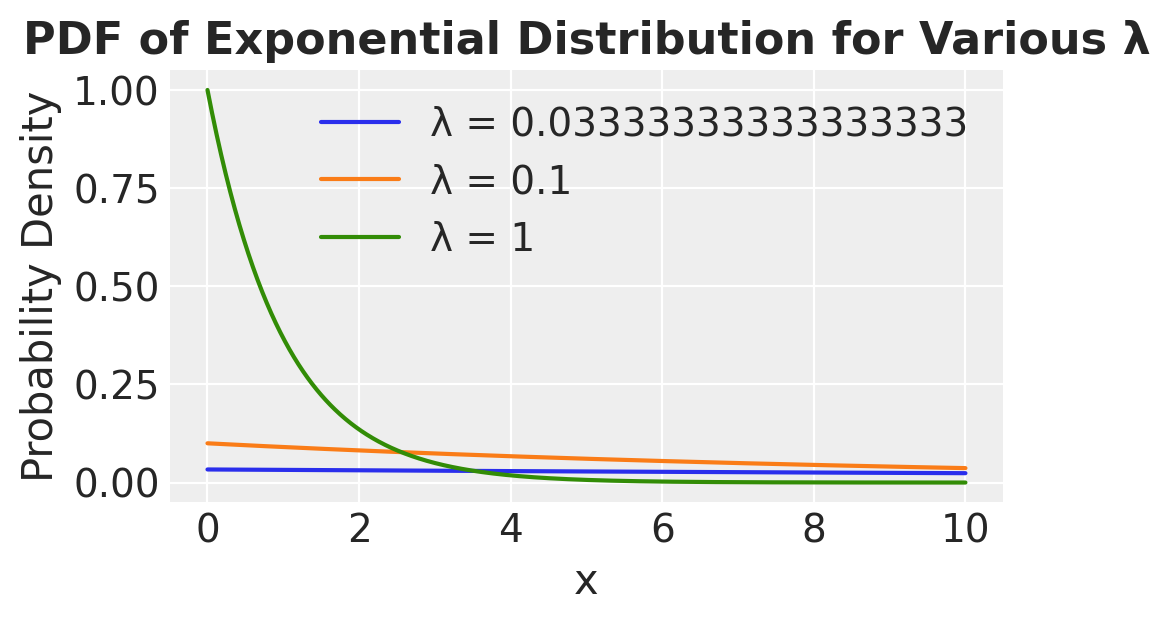

In [173]:
# Define rate parameters for the exponential distribution
rate_params = [1/30, 1/10, 1]

# Generate x values
x = np.linspace(0, 10, 1000)

# Plot the PDF for each rate parameter
plt.figure(figsize=(5, 3))
for rate in rate_params:
    scale = 1 / rate  # Convert rate (lambda) to scale parameter for scipy.stats
    pdf_values = stats.expon.pdf(x, scale=scale)
    plt.plot(x, pdf_values, label=f'λ = {rate}')

plt.title('PDF of Exponential Distribution for Various λ')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

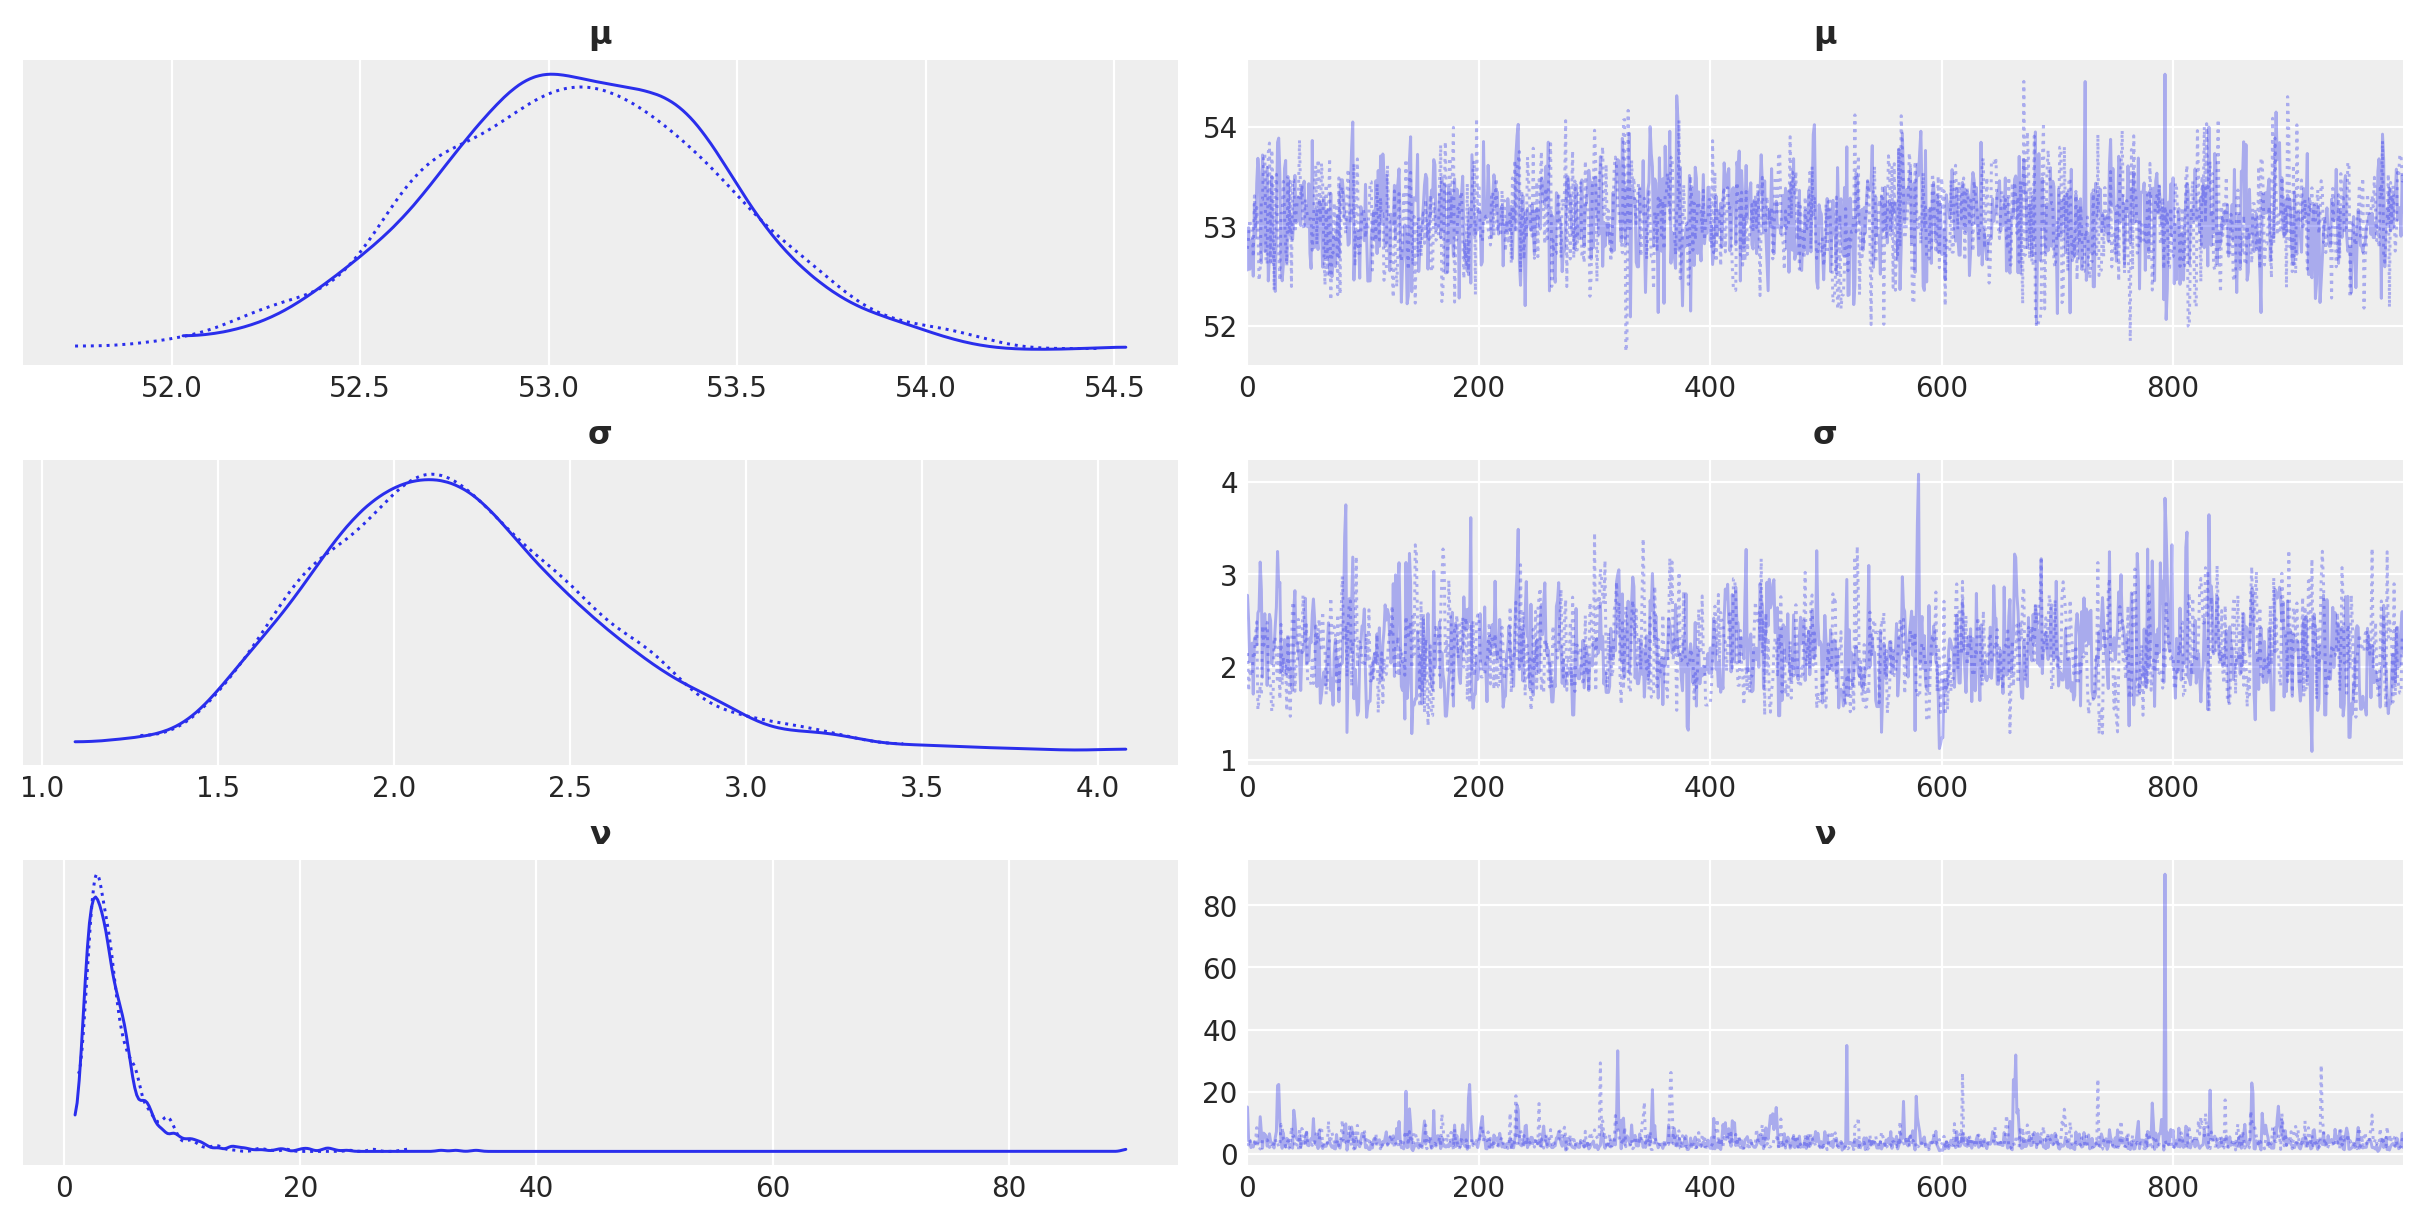

In [174]:
az.plot_trace(idata_t)


In [175]:
az.summary(idata_t)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ  53.074  0.399  52.276   53.793      0.009    0.007    1765.0    1021.0   
σ   2.181  0.401   1.476    2.927      0.013    0.009     919.0    1034.0   
ν   4.496  3.708   1.243    9.300      0.112    0.079    1068.0     996.0   

   r_hat  
μ    1.0  
σ    1.0  
ν    1.0

Text(0.5, 0, 'y')

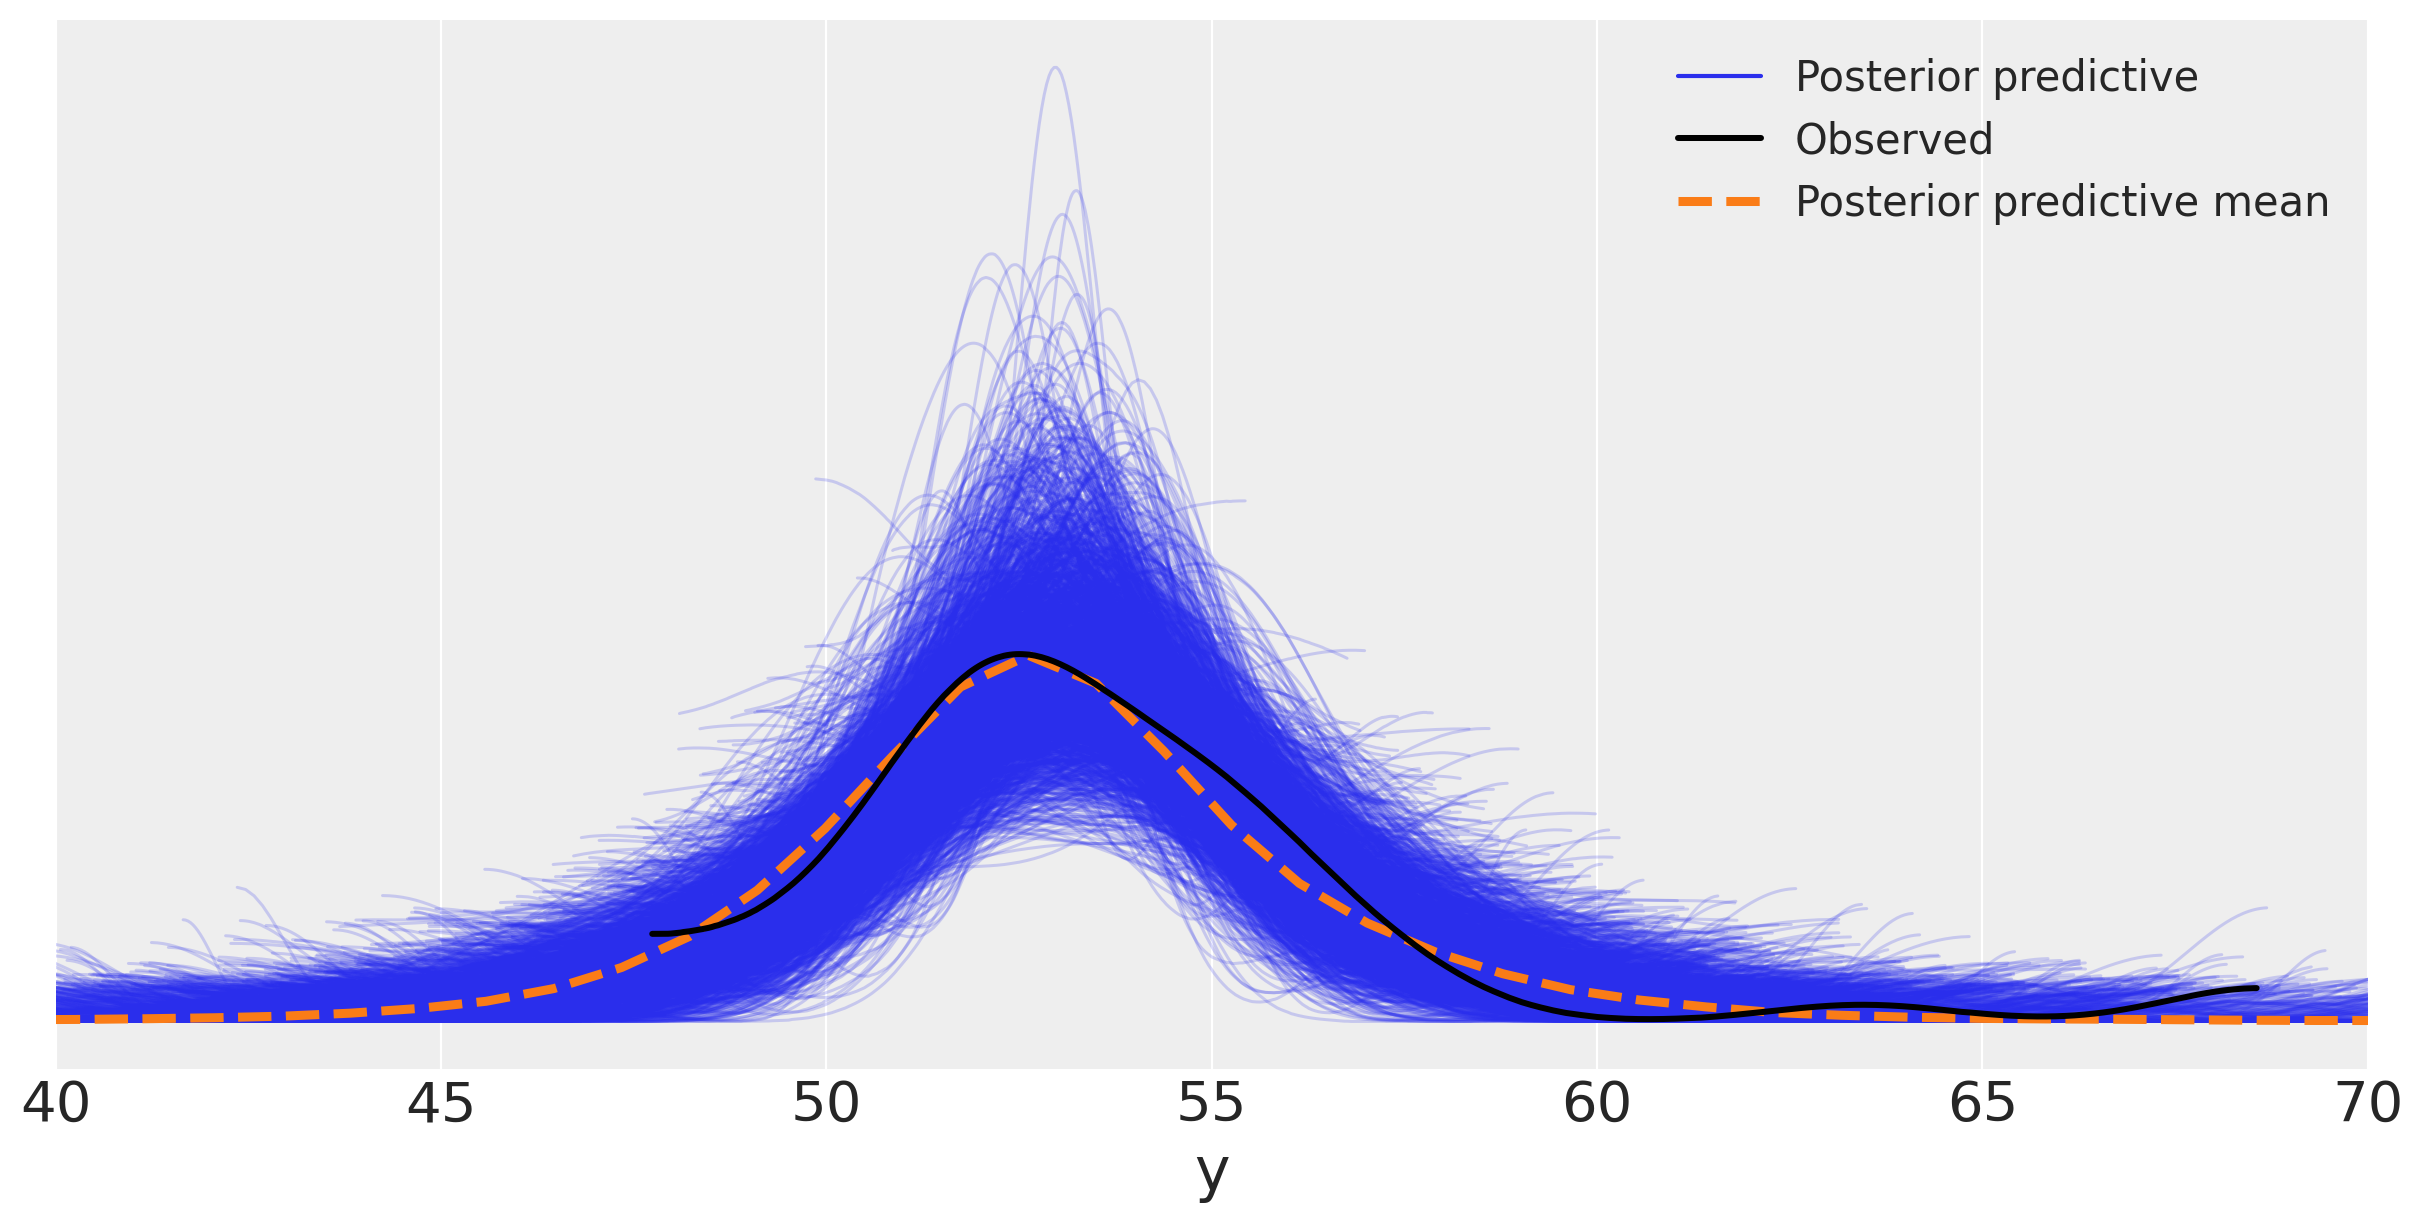

In [176]:
y_pred_t = pm.sample_posterior_predictive(idata_t, model_t)


ax = az.plot_ppc(y_pred_t, figsize=(12,6), mean=True)
ax.legend(fontsize=15)
plt.xlim(40, 70)
plt.xlabel('y')

### Updating beliefs

During the last lecture we discussed about how to update beliefs with new observations.

The posterior calculated through our model from a previous set of observations becomes the new prior for our model, where this time in the likelihood we utilize the new observations...  

First, we need to capture the posterior. The following function will be very useful.

In [199]:
from pymc.distributions import Interpolated

def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 1000)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    #x = np.concatenate([[x[0] - 1.5 * width], x, [x[-1] + 1.5 * width]])
    #y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

Now let's assume we have two additional observations; e.g., let; suppose they are:

In [200]:
new_observations = [53, 81]

One data pointfalls in the core of the distribution, the other data point occurs at the tail.

In [202]:
with pm.Model() as model_t:

    μ = from_posterior("μ", np.asarray(idata_t.posterior["μ"]).reshape(-1))
    σ = from_posterior("σ", np.asarray(idata_t.posterior["σ"]).reshape(-1))
    ν = from_posterior("ν", np.asarray(idata_t.posterior["ν"]).reshape(-1))

    y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=new_observations)
    idata_t_update = pm.sample(1000,tune=3000,return_inferencedata=True)



array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>]],
      dtype=object)

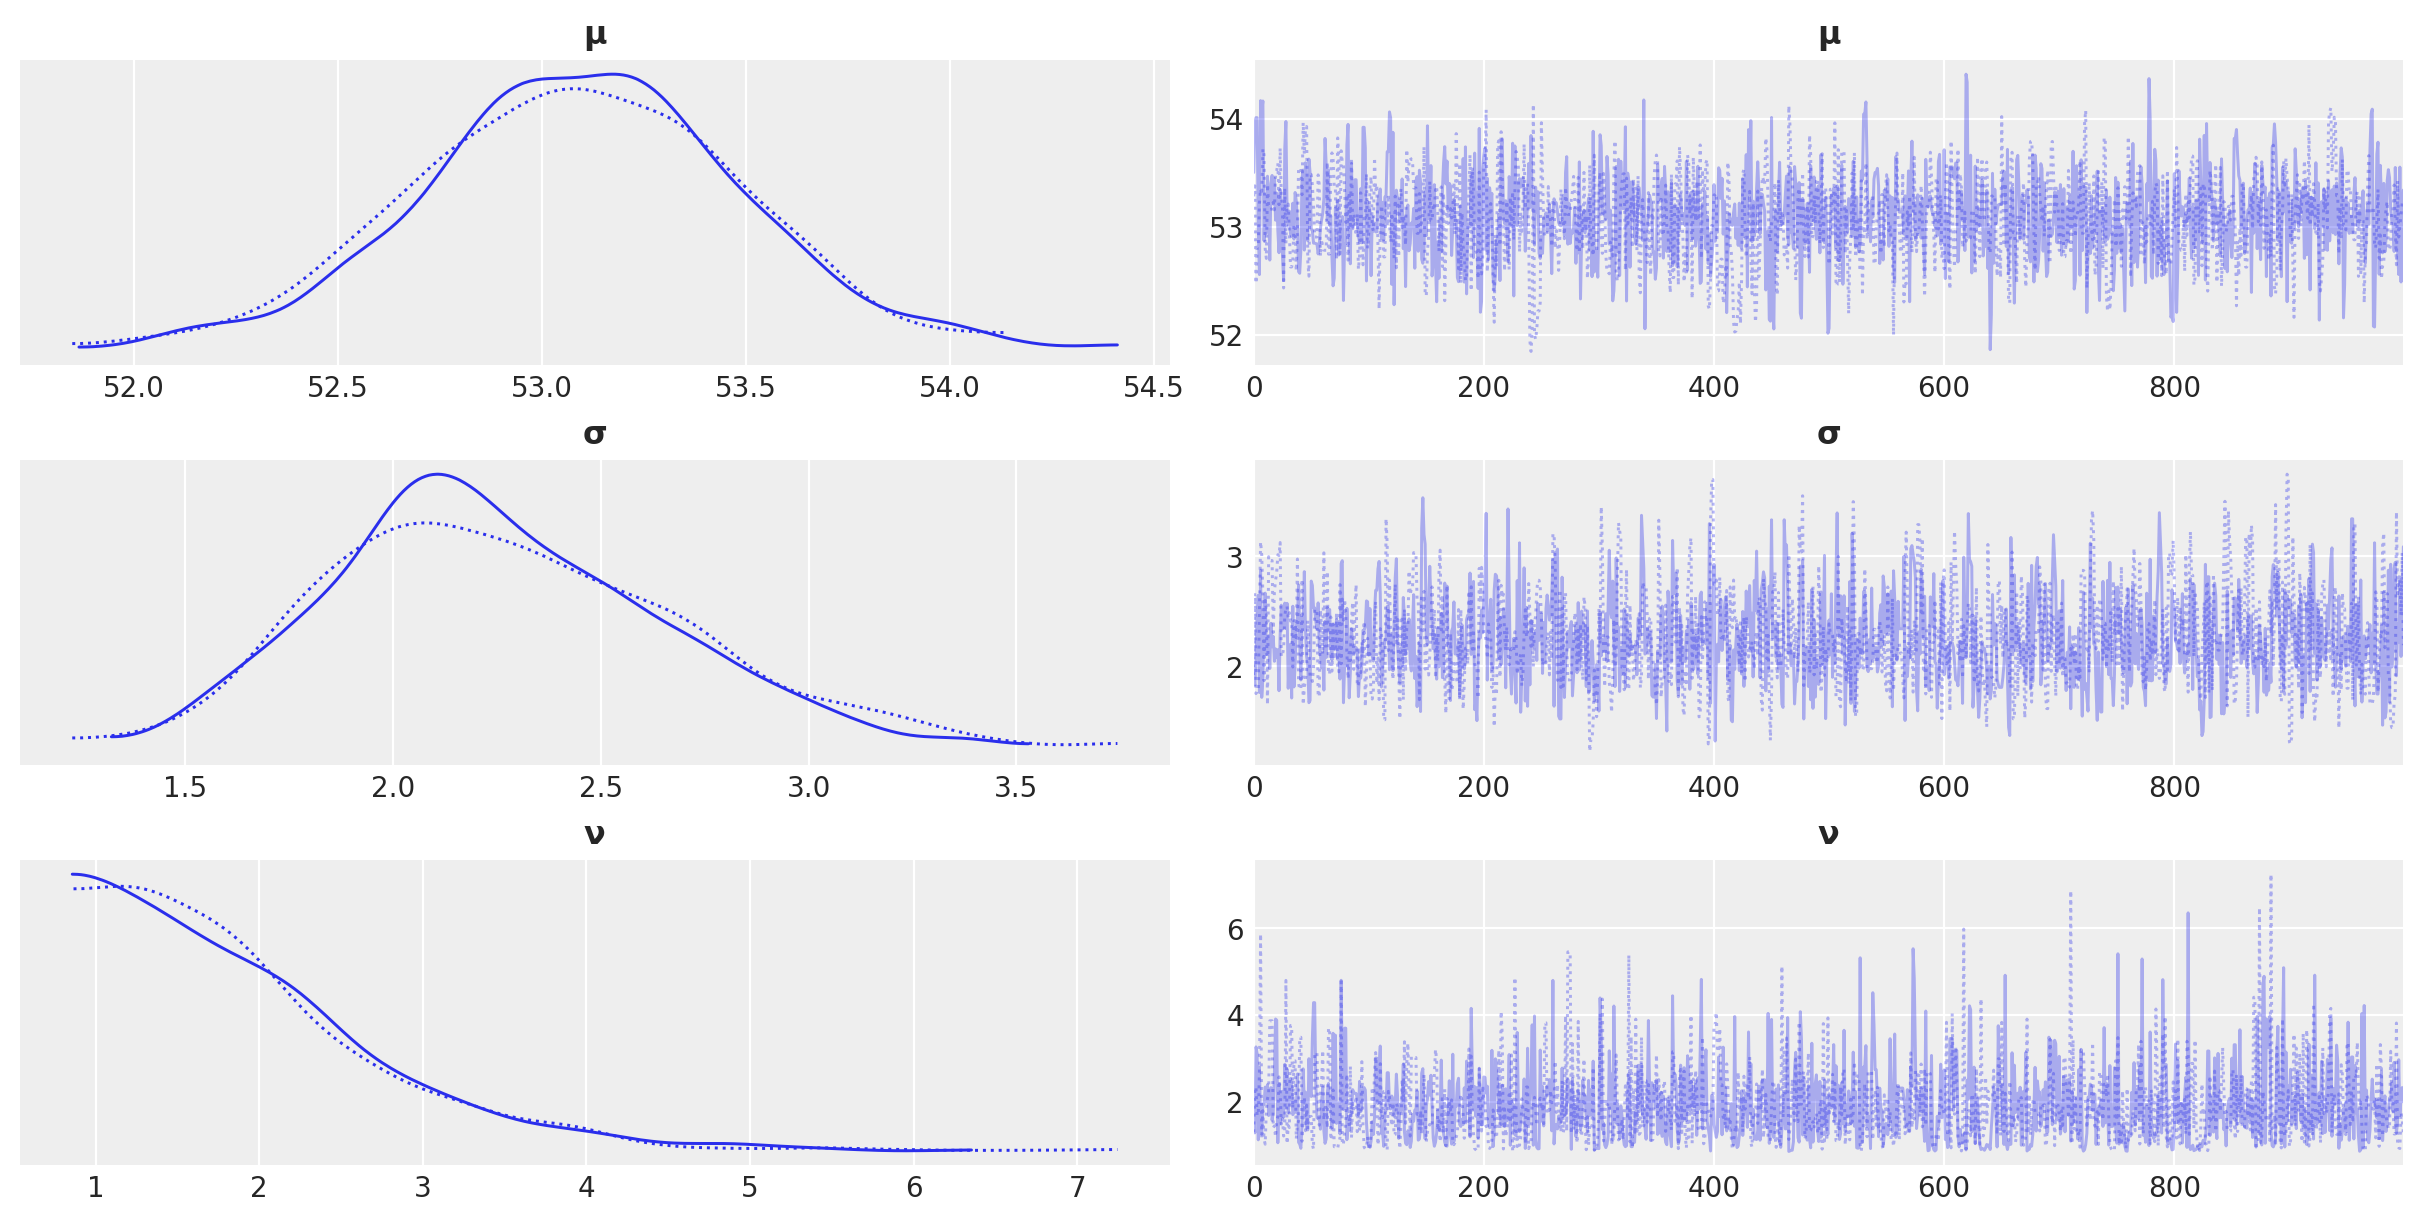

In [203]:
az.plot_trace(idata_t_update, compact= True)


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>,
       <Axes: title={'center': 'ν'}>], dtype=object)

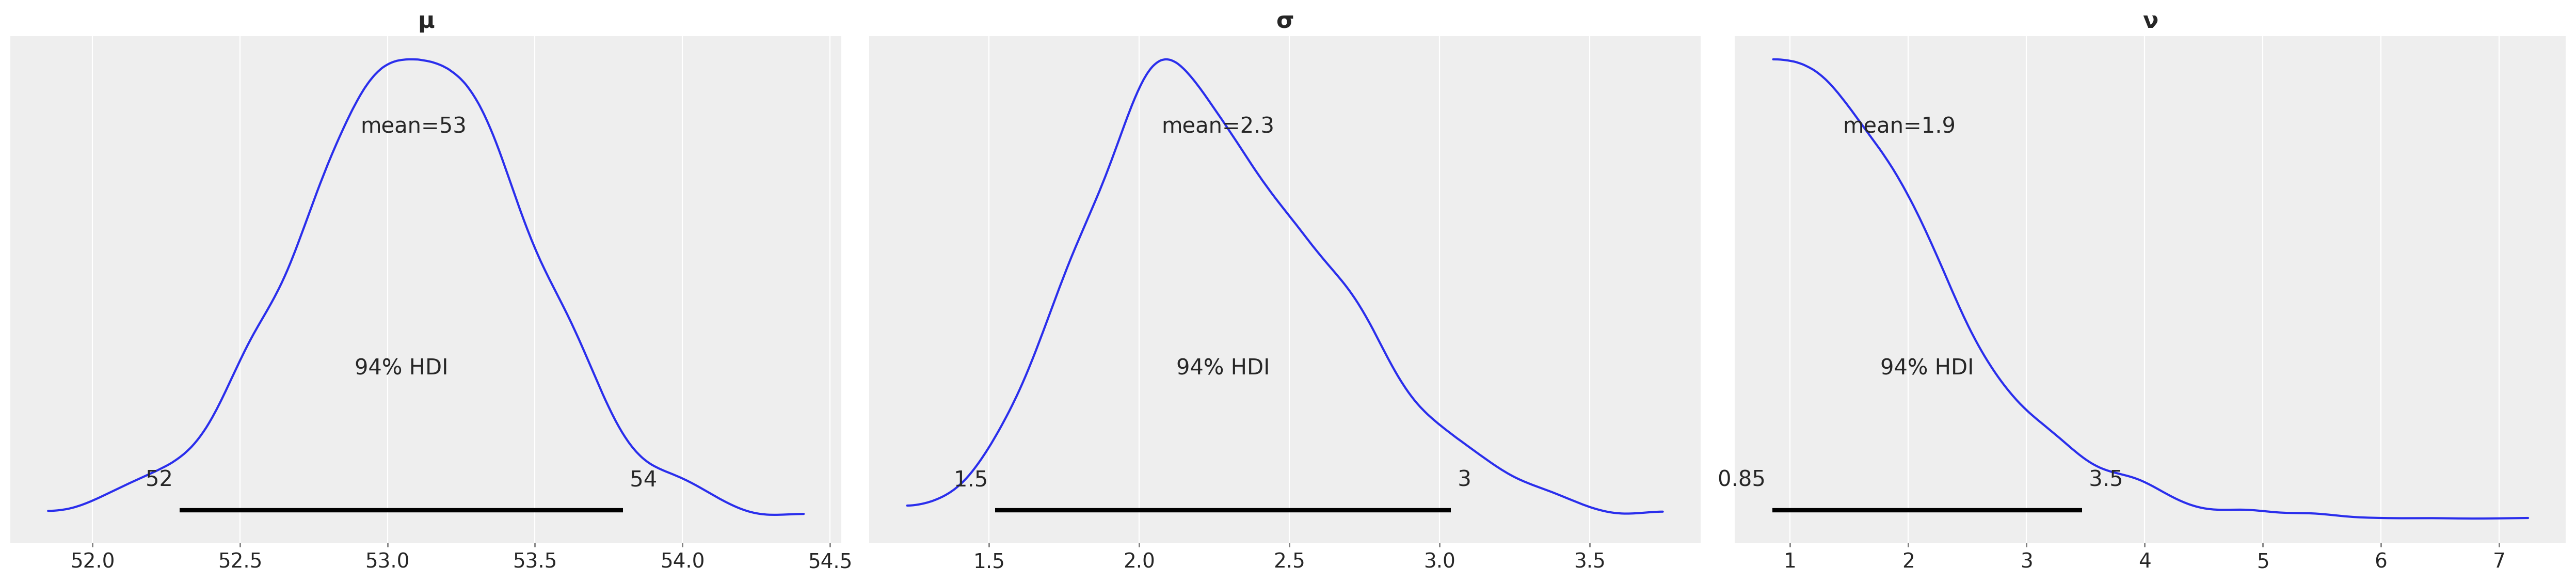

In [204]:
az.plot_posterior(idata_t_update)